<H3> Introduction </H3>
Forecasting demand is important in many practial applications including food, retail, energy and finance. The goal of this project is to predict how many food items (num_orders) will be ordered from different distribution centers (center_id) serving different types of meals (meal_id). The objective is to predict the number of orders (num_orders) for the next 10 time-steps (week 146 to 155) minimizing the total root-mean-squared-error (RMSE). Thanks to Analytics Vidhya for providing this dataset. More information can be found here: https://datahack.analyticsvidhya.com/contest/genpact-machine-learning-hackathon-1/

In [1]:
import sys
import numpy as np  
import pandas as pd
import ml_vis_eda 
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
import pickle
import lightgbm as lgb
pd.set_option('display.max_columns', None)  # displays all columns (wrap-around) in pandas statistics .info(), .corr(), .describe() etc

In [2]:
# files needed for this dataset
df_name = 'foodDemand_train/train.csv'  # training data filename
df_test_name = 'foodDemand_train/food_Demand_test.csv'  # features for the data to predict  
df_sample_name = 'foodDemand_train/sample_submission.csv'  # example (feature predictions) filename for Kaggle (formatting)
df_predictions_name = 'foodDemand_train/kaggle_submission.csv'  # final submissions (target predictions) filename for Kaggle
Additional_merge_dfs = {'foodDemand_train/fulfilment_center_info.csv': 'center_id', 'foodDemand_train/meal_info.csv': 'meal_id'}


**run_mode** variable is used to validate the entire code right from the start.

Normally to submit predictions with **run_mode=0**, the code runs on the entire train data file (weeks 1 to 145) and makes forecasts using the test file (weeks 146 to 155).

Alternatively, with **run_mode=1**, the train file is separated into a new train file (weeks 1 to 135) and new test file (weeks 136 to 145). Then using **run_mode=2**, the code can run on the new files end-to0end to evaluate the quality of the forecasts.

In [3]:
run_mode = 0  # How to run this program 
# run_mode = 0: Use base file-names above and write final predictions for submission to Kaggle and normal predictions
# run_mode = 1: use base file-names above and write new files for validation with 'file_name_ext' + '.csv' appended to them
# run_mode = 2: use new files (from run_mode=1) and run end-to-end, then calculate final predictions with validation                    
test_time = None  # for run_mode=1 only: number of time-steps to use for predictions (None: same number of time-steps as run-mode=0)    
file_name_ext = '_virtual'  # string to append to validateion base filenames (run_mode = 1 and 2 only)


Variables for plotting and algorithms used are provided. Confidence intervals are determined using quantile regression (quantile_alphas):

In [4]:
algorithms = ['mean value', 'LightGBM']
default_algorithm = 'LightGBM' 
plot_ts = 5 # number of individual time-series with targets, predictions and confidence intervals to plot
lgb_model_str = 'lightGBM_opt_pickles/lgb_model'  # prefix for data/model files
quantile_alphas = [0.05, 0.5, 0.95]  # predict quantiles for the predictions (used for plotting confidence intervals)

variable names (depends on the dataset). Categorical variables have more than two categories. 

In [5]:
target_feature = 'num_orders'  # this is what we will fit and predict 
categorical_features = ['center_id', 'meal_id', 'category', 'cuisine', 'city_code', 'region_code', 'center_type']                       
t_var = 'week'  # unit of 'time' (the column name in df)
id_var = 'id'  # common column to identify submission data and training data
unique_cols = ['center_id', 'meal_id']  # required columns to identify time-series uniquely 
quantile_alphas = [0.05, 0.5, 0.95]  # predict quantiles for the predictions (used for plotting confidence intervals)


The target variable **num_orders** is a non-negative integer (count-like), and therefore *poisson* loss function is used for the objective. This fits the data better than using least squares or RMSE (L2) loss for regression.
Note that during validation, the *number of boosters* (**early_stopping_round**) is determined by L2 loss since **first_metric_only: True**, as the goal of the project is to minimize L2 for the predictions.

In [6]:
nfold = 5  # number of cross-validation folds
use_important_features = 4  # start with this many current features
param_vals = {'num_leaves':None, 'learning_rate':0.05, 'max_depth':None, 'min_child_samples':40, 'objective': 'poisson',
        'metric':['l2', 'poisson'], 'early_stopping_round':1000, 'num_iterations':10000, 'verbose': -1,
        'min_split_gain': 0., 'min_child_weight': 1e-3, 'reg_alpha': 0., 'reg_lambda': 0.,                                        
        'subsample': 1.0, 'subsample_freq': 10, 'boosting_type': 'gbdt', 'first_metric_only': True}   

Below are the sequence of steps including: feature importances/relevance, feature engineering, hyperparameter optimization, and saving results.
Each step depends on the one before it. It is a good practice to check the results, accuracy and performance after each step before proceeding to the next. The file **lightgbm_order_forecasting.py** in the project directory gives more details for each step including running lightGBM https://github.com/microsoft/LightGBM.
Edit each step as necessary before running and check results after running it.
Set the step you are working on to 'True' to run and test the results of that step. 

<h4> For demonstration and simplicity, here we skip these steps, instead we perform some exploratory data analysis, load the final model results and view them. </h4>

In [7]:
find_relevant_raw_features = False  # find relevant raw features
find_relevant_eng_features = False  # feature engineering / find relevant features --> EDA used to decide on features 
do_recurrent_opt = False  # do recurrent feature selection if files do not exist
do_recurrent_opt_force = False  # always overwrite existing files
write_new_model = False  # this creates the final model with the recurrent features
write_new_data = False  # this runs the final model to generate the data predictions 

# optional parameters or hyperparameter optimization in some of the above steps
find_recurrent_features = True  # feature engineering: temporally lagged features 
use_average_target_properties = False  # use temporal average statistics (keep False because it did not help CV scores improve)
do_lr_opt = False  # optimize learning rate for gradient boosting
do_pars_opt = False  # optimize hyperparameters for gradient boosting 
test_recurrent = True  # check if recurrent features improve test and CV results for each time step


Load the raw data file and tabulate some statistics

In [8]:
# functions to create new file-names for end-to-end testing predictions (using run-mode=1, 2)
def new_file_name(fname: str, ext_in: str, ext_out: str) -> str:
    return fname.split(ext_in)[0] + ext_out + ext_in
def new_file_names(fnames: 'list(str)', ext_in: str, ext_out: str) -> 'list(str)':
    return [new_file_name(fname, ext_in, ext_out) for fname in fnames]
if run_mode == 2:  # get virtual file names to read
    df_name, df_test_name, df_sample_name = new_file_names(
        [df_name, df_test_name, df_sample_name], '.csv', file_name_ext)

# read in the data 
df = ml_vis_eda.pd_read_csv_stats_describe(df_name)


foodDemand_train/train.csv - data in first 10 rows
        id  week  center_id  meal_id  checkout_price  base_price  \
0  1379560     1         55     1885          136.83      152.29   
1  1466964     1         55     1993          136.83      135.83   
2  1346989     1         55     2539          134.86      135.86   
3  1338232     1         55     2139          339.50      437.53   
4  1448490     1         55     2631          243.50      242.50   
5  1270037     1         55     1248          251.23      252.23   
6  1191377     1         55     1778          183.36      184.36   
7  1499955     1         55     1062          182.36      183.36   
8  1025244     1         55     2707          193.06      192.06   
9  1054194     1         55     1207          325.92      384.18   

   emailer_for_promotion  homepage_featured  num_orders  
0                      0                  0         177  
1                      0                  0         270  
2                      0 

Supporting needed files are loaded and prepared.

In [9]:
df_test = pd.read_csv(df_test_name)
df_sample = pd.read_csv(df_sample_name)
df_predictions = df_sample.copy()
df_predictions[target_feature] = np.nan  # to make sure all get filled in
assert all(df_test[id_var].sort_values() == df_sample[id_var].sort_values())
assert df_test[t_var].min() > df[t_var].max() # check that the data to predict happens after all the valid data
if run_mode == 2:
    lgb_model_str = lgb_model_str + file_name_ext

For **run_mode=1** only, new csv files are written and then program is terminated. Then restart program with **run_mode=2** for testing forecasts end-to-end. 

In [10]:
if run_mode == 1: # overwrite df and df_test data to test the whole code end-to-end
    end_time = df[t_var].max()  # last valid sample for testing
    if test_time_len is None:
        test_time_len = df_test[t_var].max() - end_time
    test_time = end_time - test_time_len
    # modify the dataframes 
    df_test = df[df[t_var] > test_time]
    df_sample = df_test[[id_var, target_feature]]
    df = df[df[t_var] <= test_time]
    df_name, df_test_name, df_sample_name = new_file_names(
        [df_name, df_test_name, df_sample_name], '.csv', file_name_ext)
    # write the modified csvs
    df.to_csv(df_name, index=False)
    df_test[target_feature] = np.nan
    df_test.to_csv(df_test_name, index=False)
    df_sample.to_csv(df_sample_name, index=False)
    sys.exit(f'Files written: {df_name}, {df_test_name}, {df_sample_name}. Test this script using these files by running it again with run_mode=2')

Set up the time intervals that define the training/validation, test and prediction data

In [11]:
start_time = df[t_var].min()  # first sample
end_time = df_test[t_var].max()  # last sample to predict
test_time = df[t_var].max()  # last valid sample
tstep = end_time - test_time
df = pd.concat((df, df_test), axis=0)  # avoids errors later if manipulating df_test and df_tree differently
train_time = test_time - tstep

Plot histograms for all features

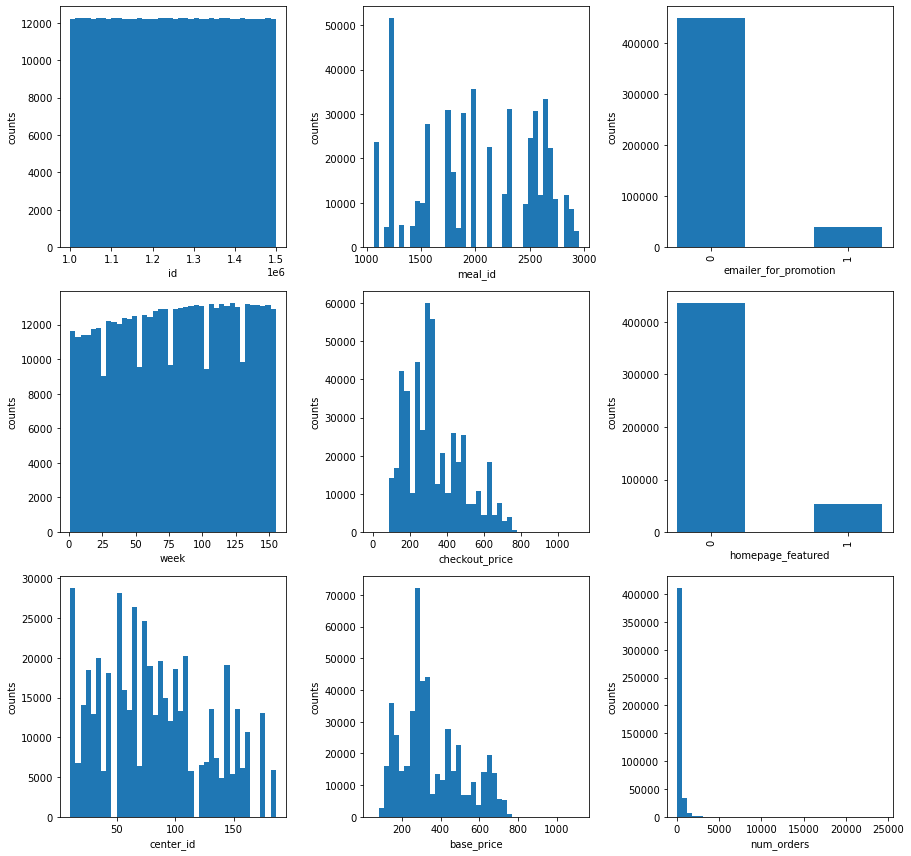

In [12]:
ml_vis_eda.plot_multiple(df.values, df.columns, targets=df[target_feature], target_label=target_feature, 
        nbins=40, no_data=np.nan, range_targets=[0., 1500.], cmap=None)

Merge the columns from all of the datasets to see if there is additional information that can help the model more accurately 

In [13]:
for merge_df, merge_col in Additional_merge_dfs.items():
    df_to_merge = ml_vis_eda.pd_read_csv_stats_describe(merge_df)
    df = df.merge(df_to_merge, on=merge_col)


foodDemand_train/fulfilment_center_info.csv - data in first 10 rows
   center_id  city_code  region_code center_type  op_area
0         11        679           56      TYPE_A      3.7
1         13        590           56      TYPE_B      6.7
2        124        590           56      TYPE_C      4.0
3         66        648           34      TYPE_A      4.1
4         94        632           34      TYPE_C      3.6
5         64        553           77      TYPE_A      4.4
6        129        593           77      TYPE_A      3.9
7        139        693           34      TYPE_C      2.8
8         88        526           34      TYPE_A      4.1
9        143        562           77      TYPE_B      3.8

foodDemand_train/fulfilment_center_info.csv - summary of column statistics
            count unique     top freq        mean        std    min    25%  \
center_id    77.0    NaN     NaN  NaN   83.142857  46.090219   10.0   50.0   
city_code    77.0    NaN     NaN  NaN  600.662338  66.720274 

Make the last column the target we want to predict

In [14]:
df_targets = df.pop(target_feature)
df = df.join(df_targets)
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,647,56,TYPE_C,2.0,Beverages,Thai,177.0
1,1018704,2,55,1885,135.83,152.29,0,0,647,56,TYPE_C,2.0,Beverages,Thai,323.0
2,1196273,3,55,1885,132.92,133.92,0,0,647,56,TYPE_C,2.0,Beverages,Thai,96.0
3,1116527,4,55,1885,135.86,134.86,0,0,647,56,TYPE_C,2.0,Beverages,Thai,163.0
4,1343872,5,55,1885,146.50,147.50,0,0,647,56,TYPE_C,2.0,Beverages,Thai,215.0


Sort the data so that adjacent rows represent the same time-series location with increasing time

In [15]:
df = df.sort_values(by=[*tuple(unique_cols), t_var])

**apply_unique_ts_map** identifies rows in the pandas dataframe **df** that correspond to individual time series. This is used later for time series plotting.

In [16]:
def apply_unique_ts_map(dvalues, tvalues, train_time, test_time):
    """ 
    identify individual time-series
    return row index indicators (start, end train set, end test set, end predition set) for each time-series

    :param dvalues: (int numpy array) shape = (nrows, *) each row uniquely identifies time-series 
    :param tvalues: (int numpy array) shape = (nrows,) each row represents time
    :param train_time: (int) latest time for training data 
    :param test_time: (int) latest time for test data

    return
        ts_inds_inv: [list] of size==(num_rows,) time-series index each row in df belongs to (0, 1, 2, ...
        ts_inds: [int numpy array] shape=(num_ts, 4), for each time-series (row index), columns represent row indices of input
            start time, end train time, end test time, end time
    """
    nrows = dvalues.shape[0]
    ts_inds_inv = np.zeros((nrows,), dtype=int)
    last_cur = tuple(dvalues[0])
    ts_inds = [[0] * 4]
    cur_ts = 0
    def get_t_status(tvalue):
        if tvalue > test_time:
            return 2
        elif tvalue > train_time:
            return 1
        return 0
    for ind in range(nrows):
        cur = tuple(dvalues[ind])
        tvalue = tvalues[ind]
        ts_status = get_t_status(tvalue)
        if cur != last_cur:
            ts_inds[-1][3] = ind
            ts_inds.append([ind] * 4)
            cur_ts += 1
            last_cur = cur
        ts_inds[-1][ts_status+1:] = [ind+1] * (3-ts_status)
        ts_inds_inv[ind] = cur_ts
    return np.array(ts_inds), ts_inds_inv, 
ts_inds, ts_inds_inv = apply_unique_ts_map(df[unique_cols].values, df[t_var].values, train_time, test_time)
num_ts = ts_inds.shape[0]  # the number of timeseries in the dataframe
print(f'number of time series: {num_ts}')

number of time series: 3600


Convert all category objects to natural number values for simpler computational logic, e.g. [0, 1, 2, ..., C]

In [17]:
def apply_unique_cats(df, categorical_features):
    """
    Convert a Pandas dataframe's categorical features to non-negative integer labeling, provide the feature mapping
    
    :param df: [pandas.core.frame.DataFrame] shape = (num_rows, num_columns)
    :param categorical_features: [list of str] features to modify 
    return
        df_copy: [pandas.core.frame.DataFrame] shape = (num_rows, num_columns) -- 
            copy of input df with non-negative integer labeling for all categorical_features
        cat_codes: [dict] keys gives each feature as str, values are original ordered df values
    """
    cat_codes = {}
    df_copy = df.copy()
    for cat_feature in categorical_features:
        df_copy[cat_feature], cat_values = df_copy[cat_feature].factorize(sort=True)
        cat_codes[cat_feature] = cat_values
    return df_copy, cat_codes
df_copy, cat_codes = apply_unique_cats(df, categorical_features)
# this is the one-to-one mapping for categorical features between df and df_copy 
print(cat_codes)

{'center_id': Int64Index([ 10,  11,  13,  14,  17,  20,  23,  24,  26,  27,  29,  30,  32,
             34,  36,  39,  41,  42,  43,  50,  51,  52,  53,  55,  57,  58,
             59,  61,  64,  65,  66,  67,  68,  72,  73,  74,  75,  76,  77,
             80,  81,  83,  86,  88,  89,  91,  92,  93,  94,  97,  99, 101,
            102, 104, 106, 108, 109, 110, 113, 124, 126, 129, 132, 137, 139,
            143, 145, 146, 149, 152, 153, 157, 161, 162, 174, 177, 186],
           dtype='int64'), 'meal_id': Int64Index([1062, 1109, 1198, 1207, 1216, 1230, 1247, 1248, 1311, 1438, 1445,
            1525, 1543, 1558, 1571, 1727, 1754, 1770, 1778, 1803, 1847, 1878,
            1885, 1902, 1962, 1971, 1993, 2104, 2126, 2139, 2290, 2304, 2306,
            2322, 2444, 2490, 2492, 2494, 2539, 2569, 2577, 2581, 2631, 2640,
            2664, 2704, 2707, 2760, 2826, 2867, 2956],
           dtype='int64'), 'category': Index(['Beverages', 'Biryani', 'Desert', 'Extras', 'Fish', 'Other Snacks',
       'P

Frequency histograms show how the feature distributions are related to the target feature **num_orders**.
The heights of the bars (*counts*) are the frequency of occurence for a given feature over the entire dataset (e.g. the sum of the heights of the bars is equal to the number of rows in the dataframe).
The color of each bar represents the average value of **num_orders** in that bar.

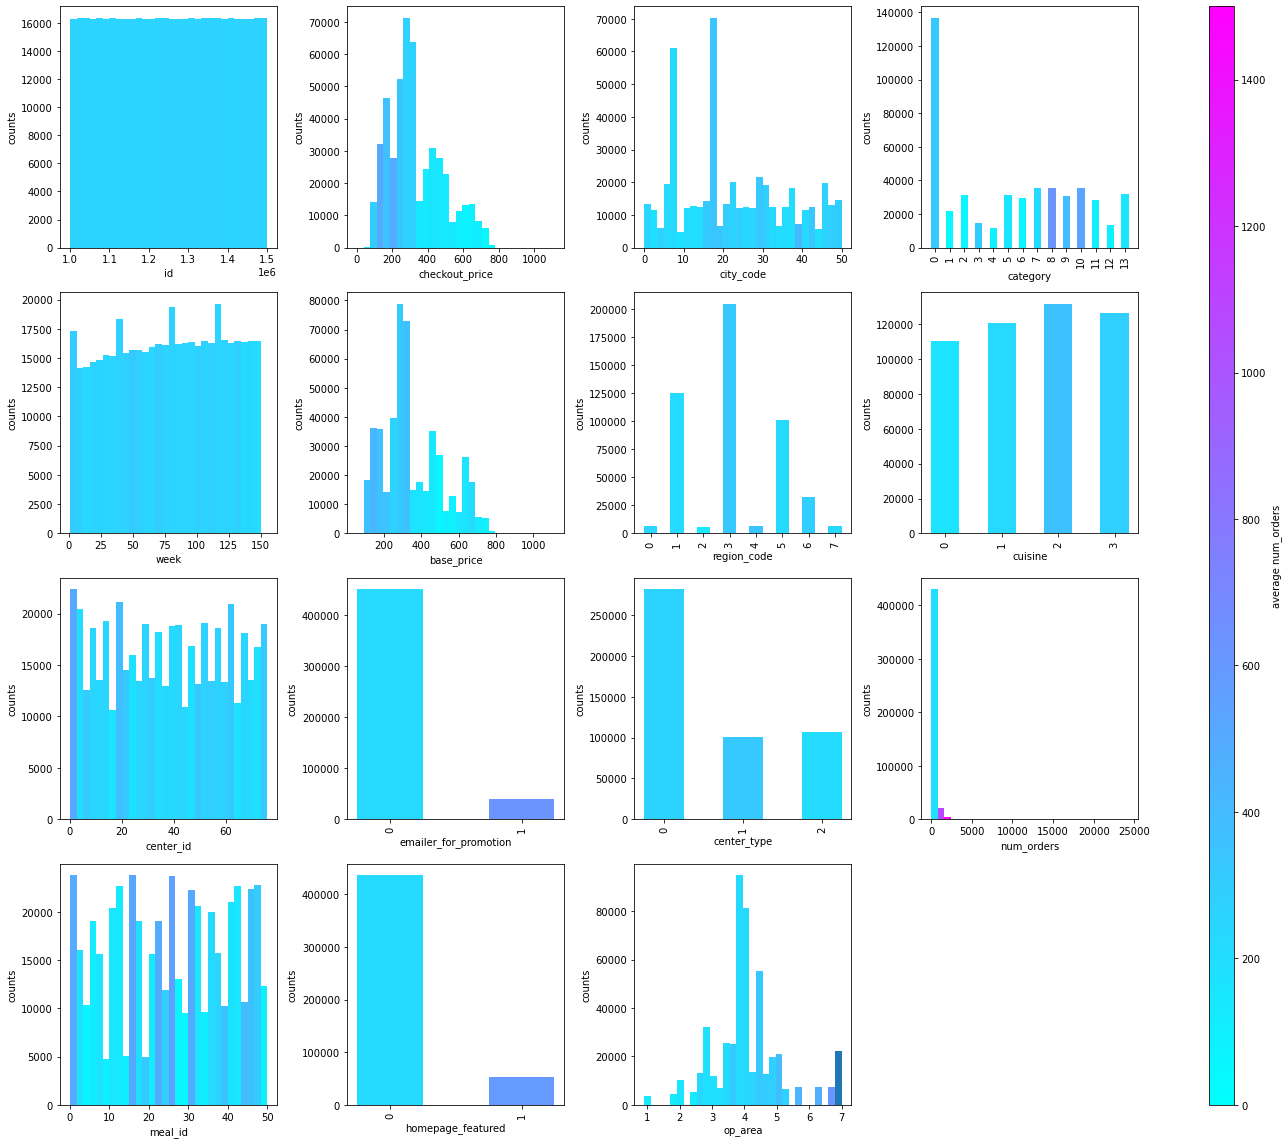

In [18]:
ml_vis_eda.plot_multiple(df_copy[df_copy.columns].values, df_copy.columns, targets=df_copy[target_feature], target_label=target_feature, nbins=30, no_data=-1, range_targets=[0., 1500.], cmap=mpl.cm.cool)

The color variation indicates that **num_orders** depends strongly on **emailer_for_promotion**, **homepage_featured**, **base_price**, **checkout_price** and **op_area**.

The relationship between features is shown below using *spearman ranking* correlation coefficient which is reasonable for all variables that can ordered including numerical and binary categorical features, but not categorical variables with more than one category.

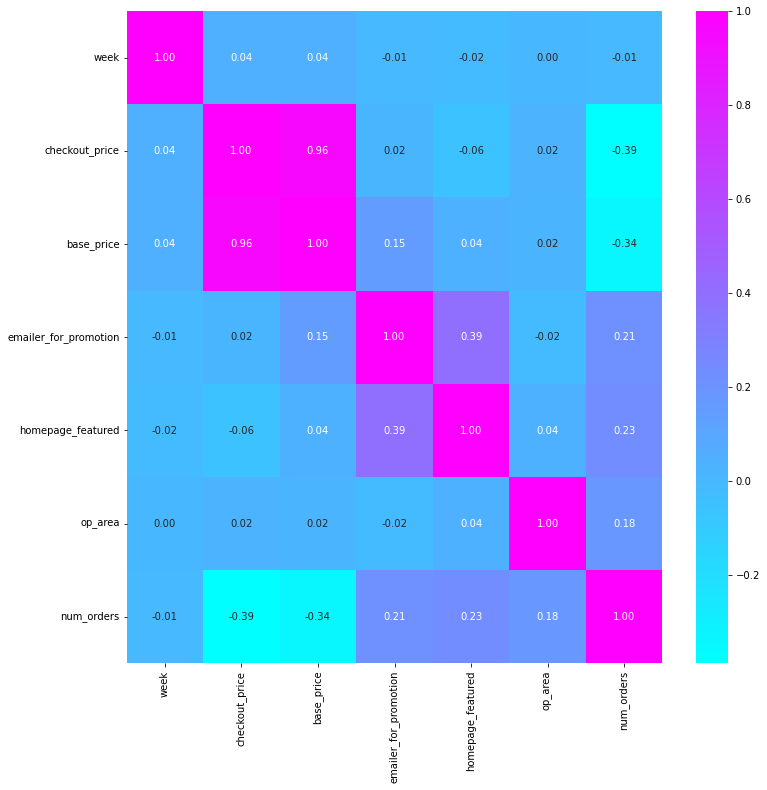

In [19]:
ordered_features = ['week', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'op_area', 'num_orders']
ml_vis_eda.plot_corr(df_copy[ordered_features], method='spearman') 

The correlation heatmap indicates that **checkout_price** and **base_price** are strongly correlated (R^2=0.96) meaning that together they do not add much new information. 

Based on the heatmap correlations, **checkout_price** is plotted below against all other features in scatter plots.
These show that the targets **num_orders** depends strongly on **checkout price** for a few of the *meal_id* categories.

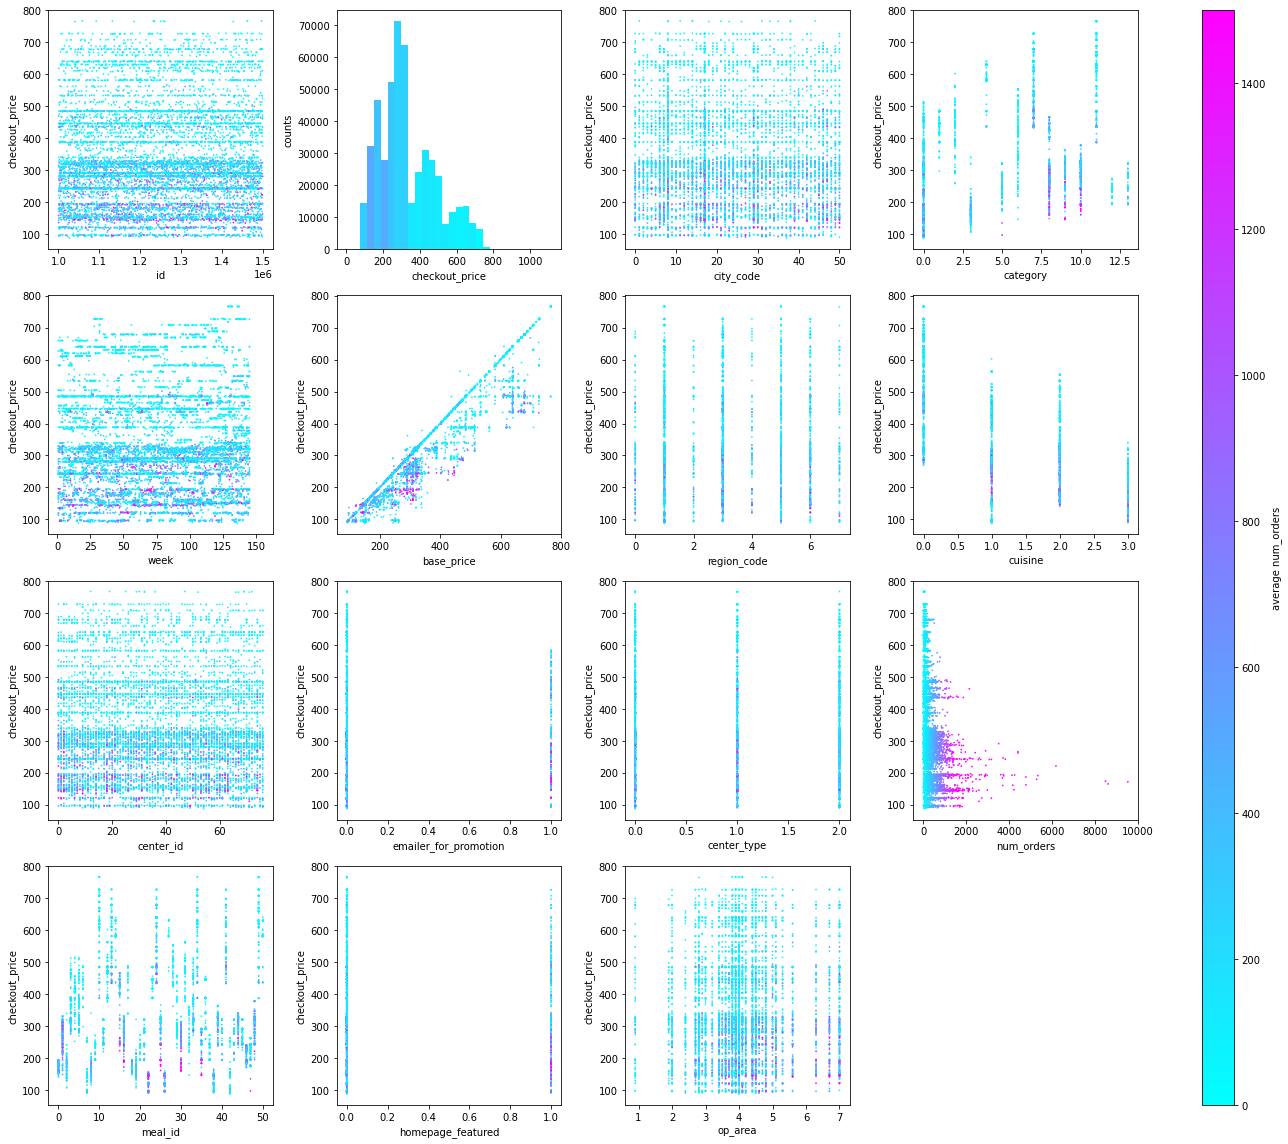

In [20]:
ml_vis_eda.plot_multiple(df_copy[df_copy.columns].values, df_copy.columns, ylabel='checkout_price', targets=df_copy[target_feature], 
            target_label=target_feature, nbins=30, no_data=-1, range_targets=[0., 1500.], cmap=mpl.cm.cool)


Feature engineering is used to create additional features:

In [21]:
df_tree = df_copy.copy()

def add_merged_feature(df_tree, columns, merge_col_name, mean_col_name=None, count_col_name=None,
        median_col_name=None, sum_col_name=None, any_col_name=None):
    if mean_col_name is not None:  # gets mean by group
        grpby_df = df_tree.groupby(columns)[mean_col_name].mean().reset_index()  
    elif count_col_name is not None:  # gets valid count by group
        grpby_df = df_tree.groupby(columns)[count_col_name].count().reset_index()  
    elif median_col_name is not None:
        grpby_df = df_tree.groupby(columns)[median_col_name].median().reset_index()
    elif sum_col_name is not None:
        grpby_df = df_tree.groupby(columns)[sum_col_name].sum().reset_index()
    elif any_col_name is not None:
        grpby_df = df_tree.groupby(columns)[any_col_name].any().reset_index()
    columns2 = list.copy(columns)
    columns2.append(merge_col_name)
    grpby_df.columns= columns2
    df_tree = df_tree.merge(grpby_df, on=columns, how='left')
    return df_tree

relevant_eng_features_fname = lgb_model_str + '_relevant_eng_features.pkl'

# start with these base features
selectable_features = [['center_id'], ['meal_id'], ['checkout_price'], ['base_price'], ['emailer_for_promotion'], 
    ['homepage_featured'], ['city_code'], ['region_code'], ['center_type'], ['op_area'], ['category'], ['cuisine']]
selectable_features.append([t_var])

# get temporal feature mean -- these inputs are known for future predictions so we can put it here
eng_cat_features = ['base_price', 'checkout_price', 'emailer_for_promotion','homepage_featured']
for eng_cat_feature in eng_cat_features:
    grp = df_tree.sort_values(t_var).groupby(['center_id', 'meal_id'])[eng_cat_feature]
    feature_name = eng_cat_feature + '_mean_ts'
    df_tree[feature_name] = grp.transform(lambda x: x.expanding().mean())
    selectable_features.append([feature_name, eng_cat_feature])

# add some engineered features 
eng_cat_features = ['center_id', 'meal_id', 'city_code',
        'region_code', 'center_type', 'category', 'cuisine']
for eng_cat_feature in eng_cat_features:
    feature_name = eng_cat_feature + '_' + t_var + '_count'
    df_tree = add_merged_feature(df_tree, [eng_cat_feature, t_var], feature_name, count_col_name='id')
    selectable_features.append([feature_name, eng_cat_feature])

# global count for each time-step
df_tree = add_merged_feature(df_tree, [t_var], t_var + '_count', count_col_name='id')
feature_name = t_var + '_count'
selectable_features.append([feature_name])

feature_name = 'ts_mean'
grp = df_tree.sort_values(t_var).groupby(['center_id', 'meal_id'])[id_var]    
df_tree[feature_name] = grp.transform(lambda x: x.expanding().count())
df_tree[feature_name] = df_tree[feature_name] / df_tree[t_var]
selectable_features.append([feature_name])

# price ratios to mean price grouped by (timestep and categorical features)
eng_cat_features = ['center_id', 'meal_id', 'city_code', 'region_code', 'center_type', 'category', 'cuisine']
for eng_cat_feature in eng_cat_features:
    eng_cat_features2 = ['base_price', 'checkout_price']
    for eng_cat_feature2 in eng_cat_features2:
        feature_name = eng_cat_feature + '_' + t_var + '_' + eng_cat_feature2 + '_ratio'
        df_tree = add_merged_feature(df_tree, [eng_cat_feature, t_var], feature_name, mean_col_name=eng_cat_feature2)
        df_tree[feature_name] = df_tree[eng_cat_feature2] / df_tree[feature_name]
        selectable_features.append([feature_name, eng_cat_feature, eng_cat_feature2])
    for eng_cat_feature2 in ['emailer_for_promotion','homepage_featured']:
        feature_name = eng_cat_feature + '_' + eng_cat_feature2 + '_mean'
        df_tree = add_merged_feature(df_tree, [eng_cat_feature, t_var], feature_name, mean_col_name=eng_cat_feature2)
        selectable_features.append([feature_name, eng_cat_feature, eng_cat_feature2])


In [22]:
print(f'All possible features:\n {list(df_tree.columns)}')

All possible features:
 ['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code', 'center_type', 'op_area', 'category', 'cuisine', 'num_orders', 'base_price_mean_ts', 'checkout_price_mean_ts', 'emailer_for_promotion_mean_ts', 'homepage_featured_mean_ts', 'center_id_week_count', 'meal_id_week_count', 'city_code_week_count', 'region_code_week_count', 'center_type_week_count', 'category_week_count', 'cuisine_week_count', 'week_count', 'ts_mean', 'center_id_week_base_price_ratio', 'center_id_week_checkout_price_ratio', 'center_id_emailer_for_promotion_mean', 'center_id_homepage_featured_mean', 'meal_id_week_base_price_ratio', 'meal_id_week_checkout_price_ratio', 'meal_id_emailer_for_promotion_mean', 'meal_id_homepage_featured_mean', 'city_code_week_base_price_ratio', 'city_code_week_checkout_price_ratio', 'city_code_emailer_for_promotion_mean', 'city_code_homepage_featured_mean', 'region_code_week_base_p

The functions below are for loading and saving models/data after various optimization or selection steps:

In [23]:
######## functions for saving/loading results from each step 
def save_model_pickle(filename, model):
    """ use Python pickle to save file to disk for later usage """
    dirname = os.path.dirname(filename)
    if not os.path.exists(dirname):
        os.mkdir(dirname)
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    
def load_model_pickle(filename):
    """ use Python pickle to load file from disk """ 
    with open(filename, 'rb') as file:
        return pickle.load(file)

def get_pickle_file_name(lgb_model_str, do_test, num_step=None, alpha=None):
    if alpha is not None:                       
        lgb_model_str = lgb_model_str + '_alpha' + str(alpha)
    if do_test:
        lgb_model_str = lgb_model_str + '_' + 'train_stage'         
    else:
        lgb_model_str = lgb_model_str + '_' + 'final_stage'                                                                    
    if num_step is not None:
        lgb_model_str = lgb_model_str + '_' + str(num_step+1)
    return lgb_model_str + '.pkl'

best_features = load_model_pickle(relevant_eng_features_fname)

In [24]:
print(best_features)

['homepage_featured_mean_ts', 'checkout_price_mean_ts', 'checkout_price', 'center_id_week_count', 'ts_mean', 'emailer_for_promotion', 'meal_id', 'center_id', 'homepage_featured', 'meal_id_week_count']


The features above were found to give a good prediction accuracy based on cross-validation from the initial set of features. Interestingly **week** is not one of them which means that the features above can explain the time-dependence better than time (*week*) itself.

Next, *stationary* time-dependence is added through lagged features with window averaging. The final set of lagged features and hyperparameters to create them are loaded from a file previously created.

In [25]:
def make_windows(window_pow, max_lag):
    """ return rolling window average length for each time lag """
    windows = []
    for lag in range(1, max_lag+1):
        window = int((lag) ** window_pow)
        windows.append(window)
    return windows

def make_lagged_series(base_colname, t_cur, unique_cols, window, t_var, df_tree):
    """ 
    return a pandas series of values for base_colname in df_tree 
    that is at time variable 't_var', 't_cur' steps into the future and averaged by 'window' into the past
    time-series must be identified uniquely by unique_cols 
    """
    if base_colname == t_var:  # find the actual time-step
        current_time = df_tree.loc[:, t_var]
    grp = df_tree.groupby(unique_cols)[base_colname]
    t_series = grp.transform(lambda x: x.shift(-t_cur).rolling(window, min_periods=1).mean())
    if base_colname == t_var:
        t_series = current_time - t_series
    return t_series

def get_lagged_colname(base_colname, t_cur, window):
    """ return str column name for a lagged feature """
    past_str = 'n' if t_cur < 0 else 'p'
    return base_colname + '_' + str(abs(t_cur)) + past_str + str(window)

def get_lagged_features(base_colname, t_var, t_min, t_max, istep, tstep, window_pow, unique_cols=None, df_tree=None, names_only=False):
    steps, windows = get_lags_windows(t_min, t_max, istep, tstep, window_pow)
    t_colnames = []
    for t_cur, window in zip(steps, windows):
        t_colnames.append(get_lagged_colname(base_colname, t_cur, window))
    if names_only:
        return t_colnames
    else:
        t_df = pd.DataFrame(index=df_tree.index) 
        for (t_colname, t_cur, window) in zip(t_colnames, steps, windows):
            t_df[t_colname] = make_lagged_series(base_colname, t_cur, unique_cols, window, t_var, df_tree)
        return t_df, t_colnames

def get_lags_windows(t_min, t_max, istep, tstep, window_pow):
    """ 
    The point to forecast is at time t = 0
    istep is the time position of the the last 'observed' data: istep <= 0
    the last 'known' data is at t = tstep + istep >= 0
    we start at istep in order to ensure that averaging windows overlap without staggering wrt istep
    """
    def get_window(cur_t, window_pow):
        return int((abs(cur_t) + 1) ** window_pow)
    steps = []
    windows = []
    if t_max > tstep + istep: 
        raise ValueError(f't_max = {t_max} cannot be greater than {tstep + istep}')
    if t_min > t_max:
        raise ValueError(f't_min = {t_min} cannot be greater than t_max={t_max}')
    # get all data before and at istep
    cur_t = istep
    cur_win = get_window(cur_t, window_pow)
    last_t = cur_t
    while cur_t > t_min:
        if cur_t == last_t:
            cur_win = get_window(cur_t, window_pow)
            if cur_t >= t_min and cur_t <= t_max and cur_t != 0: 
                steps.insert(0, cur_t)
                windows.insert(0, cur_win)
            last_t = cur_t - cur_win
        cur_t -= 1
    # get all data after istep (operation is only valid for 'known' inputs)
    cur_t = istep
    cur_win = get_window(cur_t + 1, window_pow)
    last_t = cur_t + cur_win
    while cur_t <= t_max:
        if cur_t == last_t:
            if cur_t >= t_min and cur_t <= t_max and cur_t != 0:
                steps.append(cur_t)
                windows.append(cur_win)
            cur_win = get_window(cur_t + 1, window_pow)
            last_t = cur_t + cur_win
        cur_t += 1
    return steps, windows

def modify_tree_recurrent(df_tree, observed_cols, known_cols, observed_cols_stats, unique_cols,
        t_var, t_min, t_max, istep, tstep, window_pow, best_features):
    df_tree_t = df_tree.copy()
    df_tree_t_columns = best_features.copy()
    for observed_col in observed_cols:
        t_df, t_colnames = get_lagged_features(observed_col, t_var, t_min, istep, istep, tstep, window_pow, 
                unique_cols, df_tree)
        df_tree_t = pd.concat((df_tree_t, t_df), axis=1)
        df_tree_t_columns.extend(t_colnames)
    for known_col in known_cols:
        t_df, t_colnames = get_lagged_features(known_col, t_var, t_min, t_max, istep, tstep, window_pow,
                unique_cols, df_tree)
        df_tree_t = pd.concat((df_tree_t, t_df), axis=1)
        df_tree_t_columns.extend(t_colnames)
    for observed_col_stat in observed_cols_stats:
        t_df, t_colnames = get_lagged_features(observed_col_stat, t_var, istep-1, istep, istep, tstep, 0.,
                unique_cols, df_tree)
        df_tree_t = pd.concat((df_tree_t, t_df), axis=1)
        df_tree_t_columns.extend(t_colnames)
    return df_tree_t, df_tree_t_columns

fname_recurrent_params = f"{lgb_model_str}_steps_features_params.pkl"
best_features_steps, params_recurrent, best_features = load_model_pickle(fname_recurrent_params)
print(params_recurrent)

[[-1, -16, 0, 0.4596953866951567, ['num_orders'], ['checkout_price', 'homepage_featured', 'center_id_week_count', 'week'], []], [-2, -19, 3, 0.6703694841647946, ['num_orders'], ['checkout_price', 'homepage_featured', 'meal_id_week_count'], []], [-3, -18, 1, 0.1679195064893821, ['num_orders'], ['checkout_price', 'homepage_featured', 'meal_id_week_count', 'week'], []], [-4, -18, 1, 0.1679195064893821, ['num_orders'], ['checkout_price', 'homepage_featured', 'meal_id_week_count'], []], [-5, -12, 1, 0.39183863327402246, ['num_orders'], ['checkout_price', 'homepage_featured', 'center_id_week_count', 'meal_id_week_count'], []], [-6, -12, 1, 0.39183863327402246, ['num_orders'], ['checkout_price', 'homepage_featured', 'meal_id_week_count'], []], [-7, -12, 1, 0.39183863327402246, ['num_orders'], ['checkout_price', 'homepage_featured'], []], [-8, -15, -3, 0.22309911406452448, ['num_orders'], ['checkout_price', 'homepage_featured', 'meal_id_week_count'], []], [-9, -19, 1, 0.10089407620493536, ['nu

Load the final generated forecasts (csv file) which was created using the above lagged feature parameters.

In [26]:
alphas = [None]
if quantile_alphas is not None:                                                                                        
    alphas.extend(quantile_alphas)
test_preds_gbm = [] 
final_preds_gbm = []
for ind, alpha in enumerate(alphas):
    fname_pred = lgb_model_str + '_test_alpha'+ str(alpha if alpha is not None else '_l2') +'.csv'
    fname_final = lgb_model_str + '_alpha'+str(alpha if alpha is not None else '_l2')+'.csv'
    test_preds_gbm.append(pd.read_csv(fname_pred))
    final_preds_gbm.append(pd.read_csv(fname_final))

The coefficient of determination **R^2** is dimensionless and inversely related to the L2 loss, It is used to evaluate the forecasting predictions and confidence (quantile) estimates.

In [27]:
def get_R2_score(predictions, target_values, weights=None):
    """ 
    Calculate final score (R**2 value) 
    Note that sklearn.metrics.r2_score gives weird results when input arrays are not flattened

    :param predictions: [np.array] predicted values
    :param target_values: [np.array] corresponding target values
    :param weights: [np.array] inverse variance estimates

    :Return float
    """
    predictions_f = predictions.astype('f8')
    target_values_f = target_values.astype('f8')
    if weights is None:
        weights_f = np.ones_like(predictions_f)
    else:
        weights_f = weights.astype('f8')
    unexplained_var = np.mean(weights_f * (target_values_f - predictions_f)**2)  # unexplained weighted variance
    mean_target_value = np.sum(target_values_f * weights_f) / np.sum(weights_f)  # weighted average
    explained_var = np.mean(weights_f * (target_values_f - mean_target_value)**2)  # explained weighted variance
    return 1. - unexplained_var / explained_var

def get_lgb_scores(df, preds_gbm, id_var, target_feature, alphas):
    df_tree_scores = []
    for ind, alpha in enumerate(alphas):
        preds_gbm_ = preds_gbm[ind]
        mask_gbm = df[id_var].isin(preds_gbm_[id_var])
        lgb_targets = df[mask_gbm].sort_values(id_var)[target_feature].values
        lgb_preds = preds_gbm_.sort_values(id_var)[target_feature].values
        df_tree_scores.append(get_R2_score(lgb_preds, lgb_targets))
        print(f'alpha: {alpha}, score: {df_tree_scores[-1]}')
    return df_tree_scores

print('test scores: ')
df_tree_test_scores =  get_lgb_scores(df_tree, test_preds_gbm, id_var, target_feature, alphas)
if run_mode == 2:
    print('final scores:' )
    df_tree_final_scores = get_lgb_scores(df_sample, final_preds_gbm, id_var, target_feature, alphas)


test scores: 
alpha: None, score: 0.8571233099910697
alpha: 0.05, score: 0.39415371574864855
alpha: 0.5, score: 0.8558968843164776
alpha: 0.95, score: 0.5731749740670733


Define features to plot vs time and plot averaged time series.

 Averaging repeated points for []:[0]


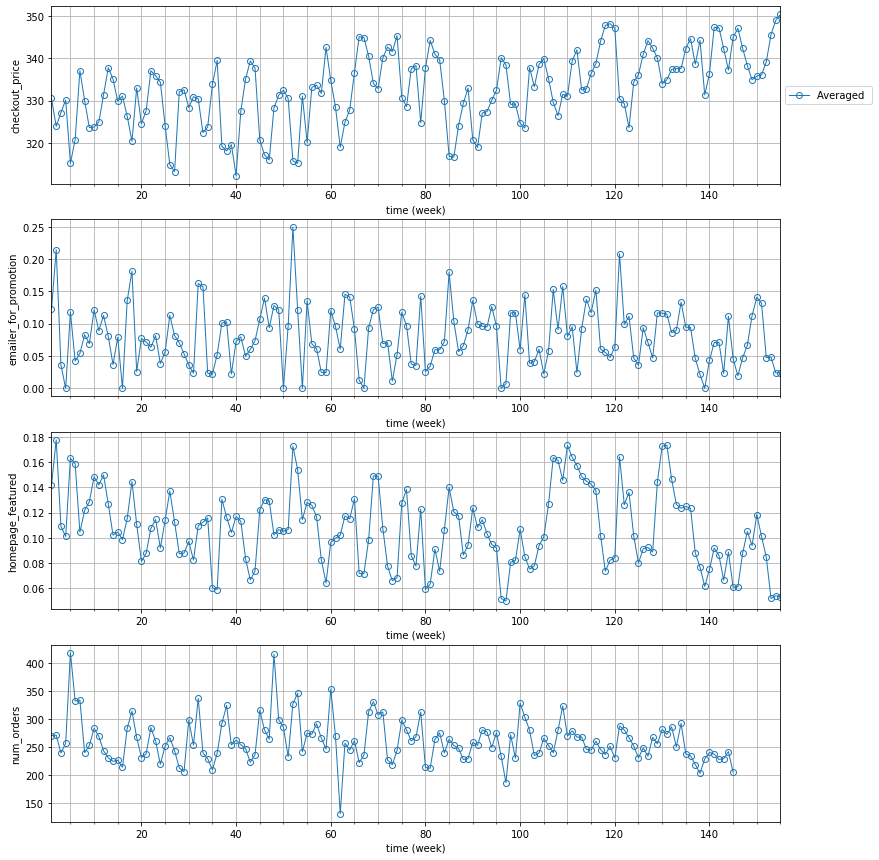

Showing plots 0 to 1 from a total of 1 categories


(0, 1, 1)

In [28]:
plot_cols = ['checkout_price', 'emailer_for_promotion', 'homepage_featured', 'num_orders']  # time-varying parameters to plot 
num_pars = len(plot_cols) # number of features 
default_alg_index = algorithms.index(default_algorithm) 

# populate known data for plotting/visualization of time series
if run_mode == 2:
    for row in df_sample.iterrows():
        df.loc[df[id_var] == row[1][id_var], target_feature] = row[1][target_feature]

# By plotting averaged quantities vs time we see that target_feature is correlated with 'emailer_for_promotion' and 'homepage_featured'
ml_vis_eda.df_plot_ts(df_copy, t_var, f'time ({t_var})', ycols=plot_cols, ylabels=plot_cols)


The plots of time-averaged time series show that **checkout_price** has evidence that it increases slowly with time. Below are the averaged features grouped by region code.

 Averaging repeated points for ['region_code']:[23]
 Averaging repeated points for ['region_code']:[34]
 Averaging repeated points for ['region_code']:[35]
 Averaging repeated points for ['region_code']:[56]
 Averaging repeated points for ['region_code']:[71]
 Averaging repeated points for ['region_code']:[77]
 Averaging repeated points for ['region_code']:[85]
 Averaging repeated points for ['region_code']:[93]


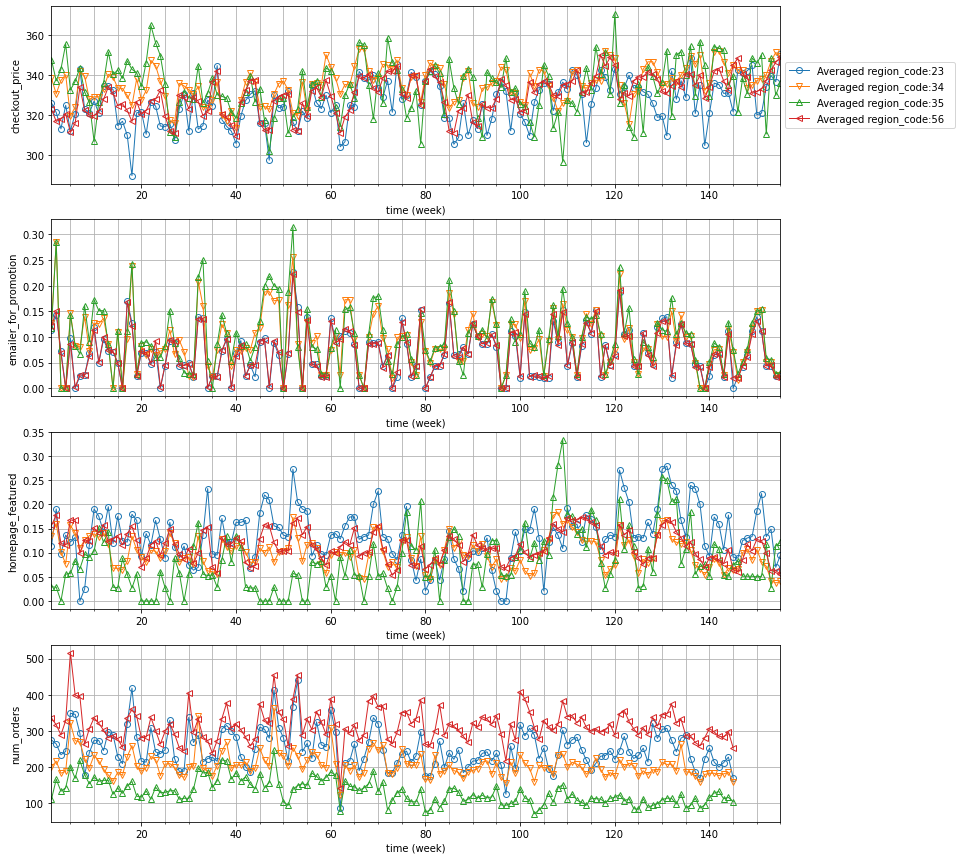

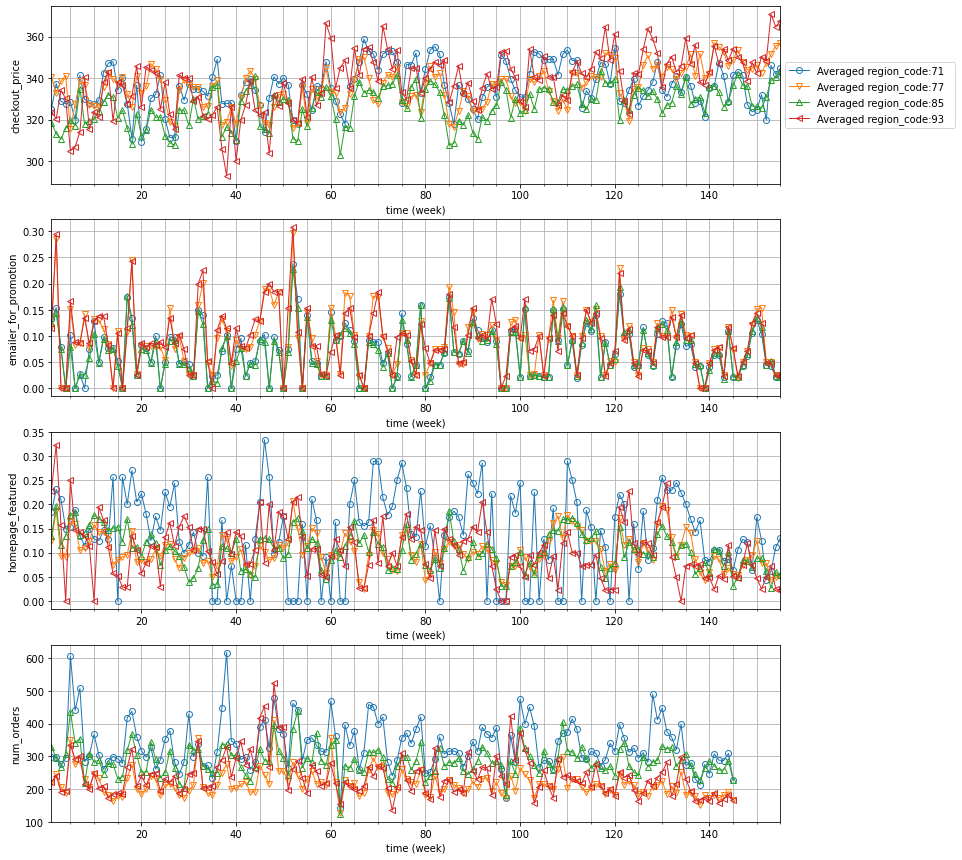

Showing plots 0 to 8 from a total of 8 categories


(0, 8, 8)

In [29]:
ml_vis_eda.df_plot_ts(df, t_var, f'time ({t_var})', plot_cols, plot_cols, col_keyvals={}, cat_cols=['region_code'], end=1000, max_plots=4)
                      

The time series averaged by category for center_id=55 are shown below:

 Averaging repeated points for ['category']:['Beverages']
 Averaging repeated points for ['category']:['Biryani']
 Averaging repeated points for ['category']:['Desert']
 Averaging repeated points for ['category']:['Extras']
 Averaging repeated points for ['category']:['Fish']


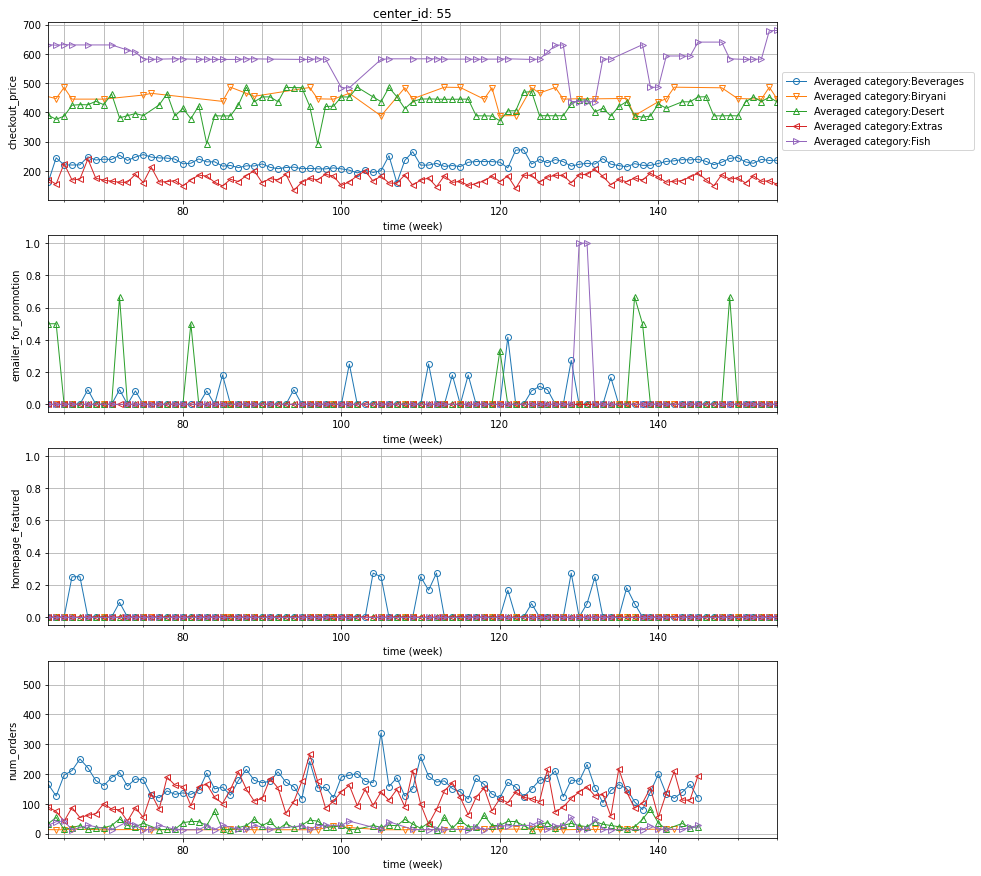

Showing plots 0 to 5 from a total of 13 categories


(0, 5, 13)

In [30]:
ml_vis_eda.df_plot_ts(df, t_var, f'time ({t_var})', ycols=plot_cols, ylabels=plot_cols, col_keyvals={'center_id': 55}, 
            cat_cols=['category'])

Randomly-selected time-series identified uniquely by **center_id** and **meal_id** are plotted below.
There is a validation (test) prediction (weeks 136-145) plot followed by the forecasting (weeks 146-155) plot for each time series identifier. The target (**num_orders**) 90% confidence interval (*quantile*), *median* (50% quantile), and the *RMSE* estimates, as well as the *mean* of previous training data are shown for comparisons.

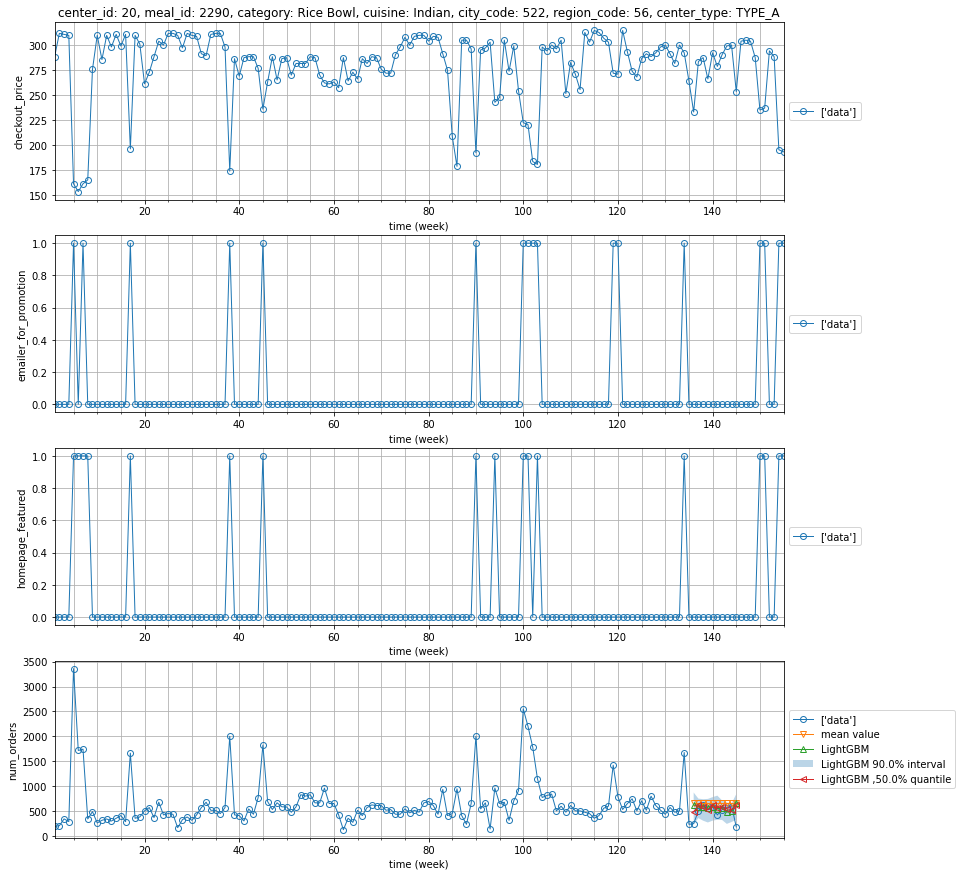

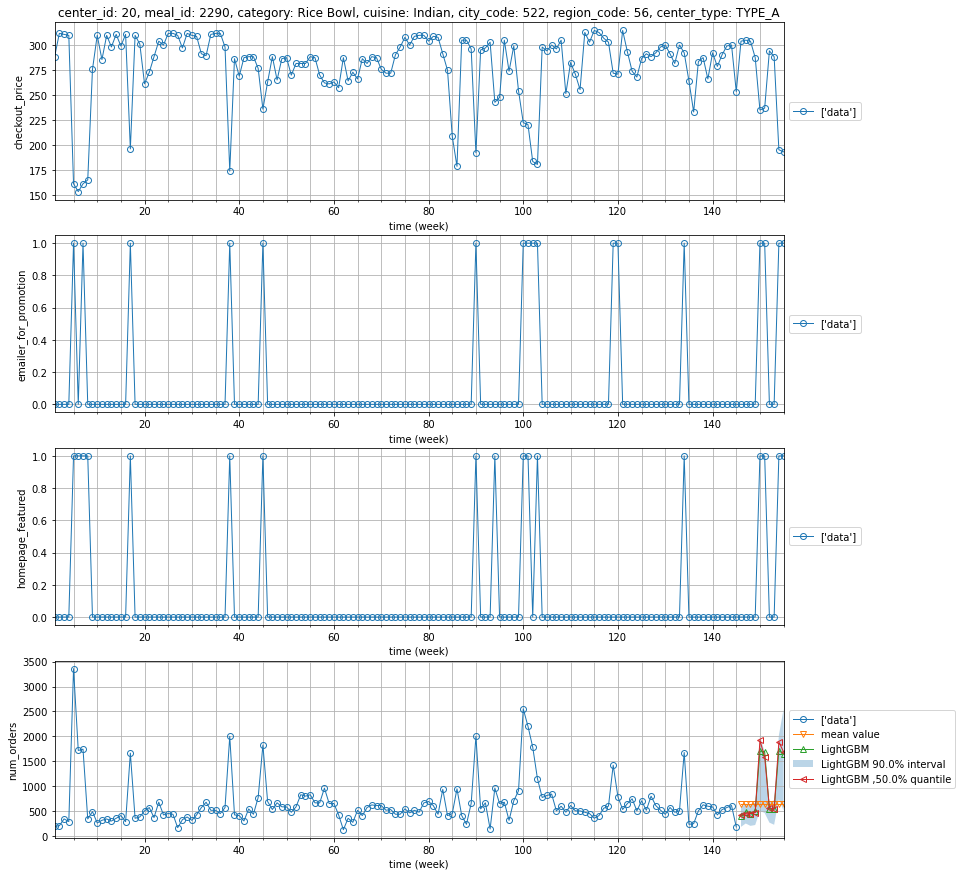

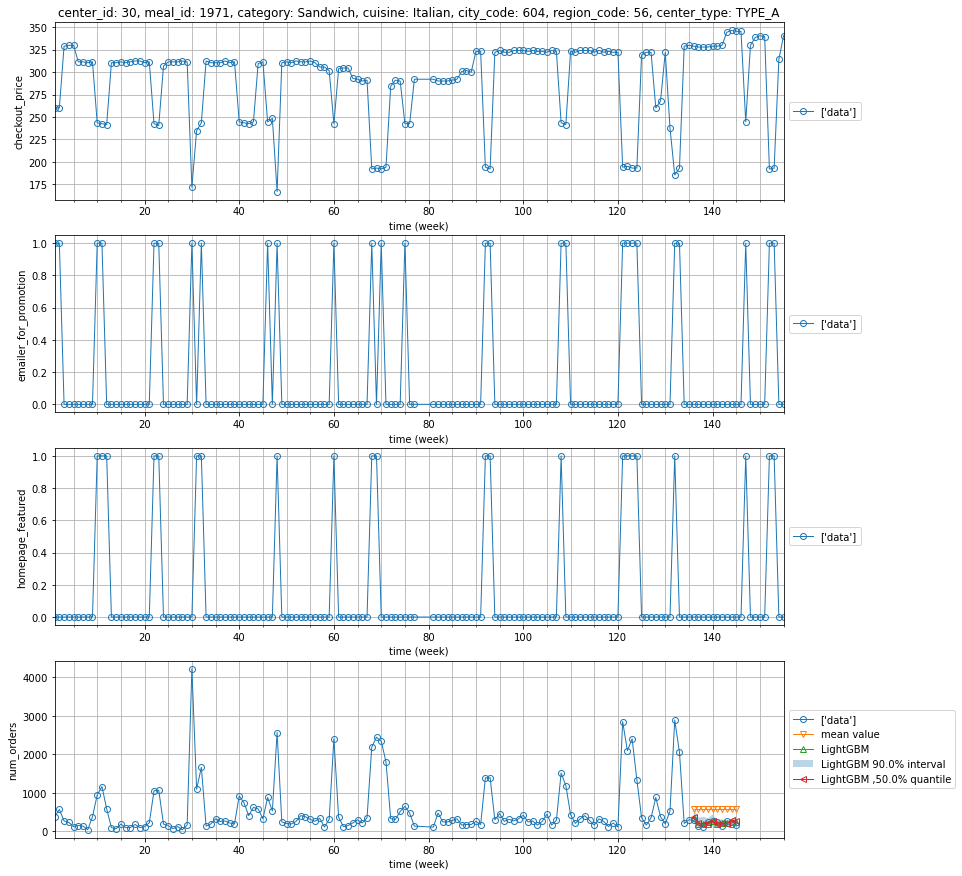

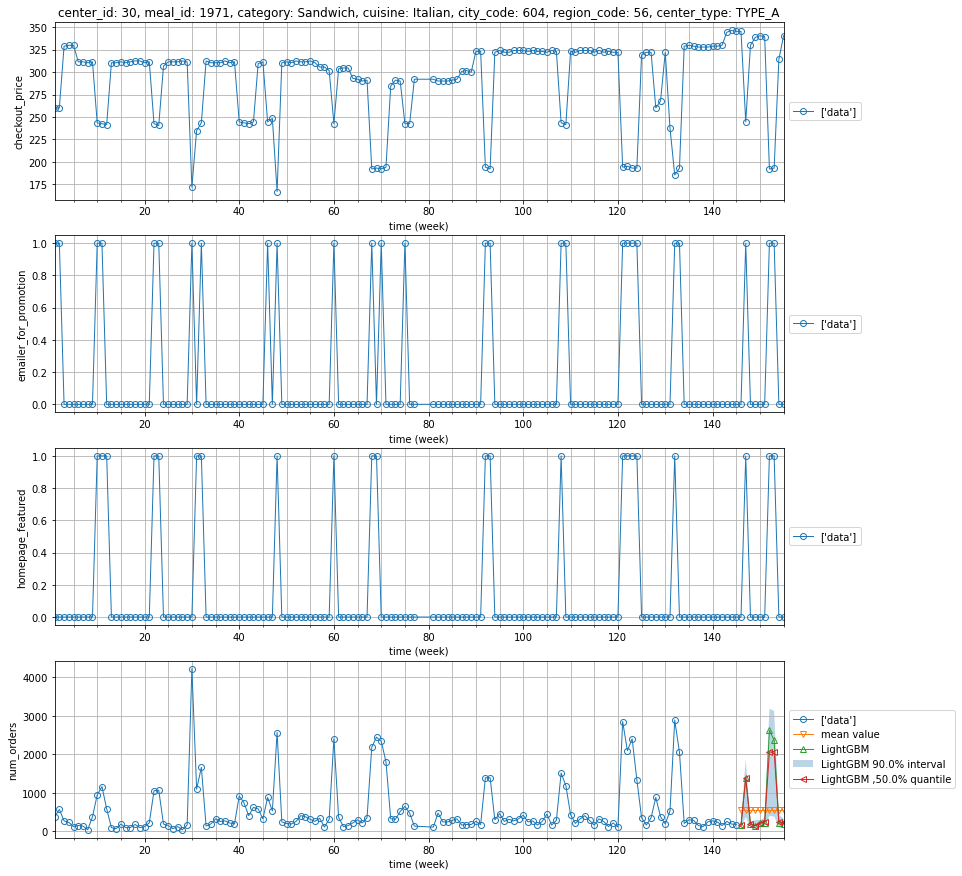

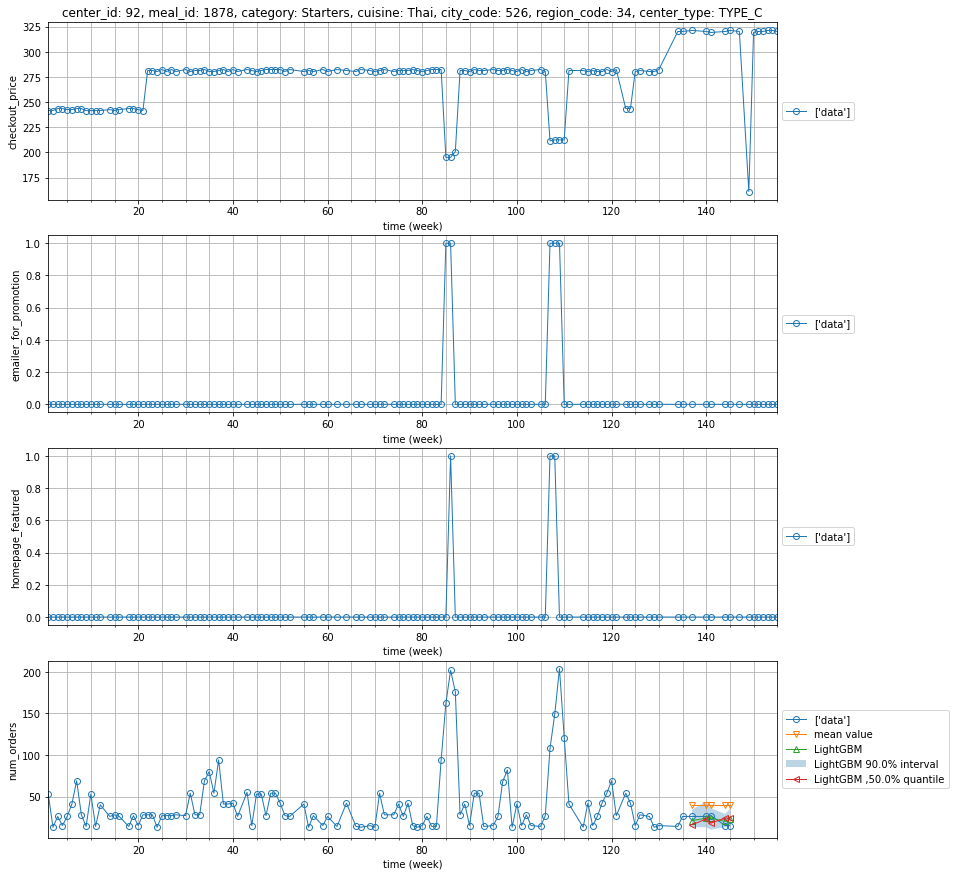

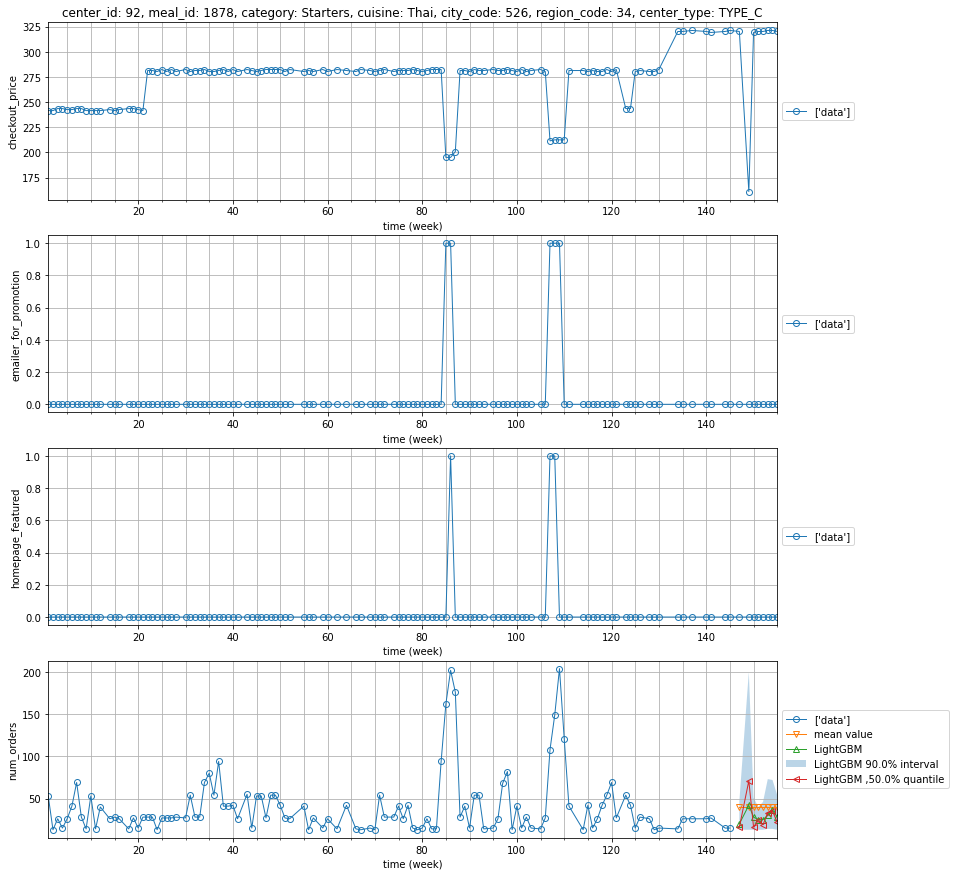

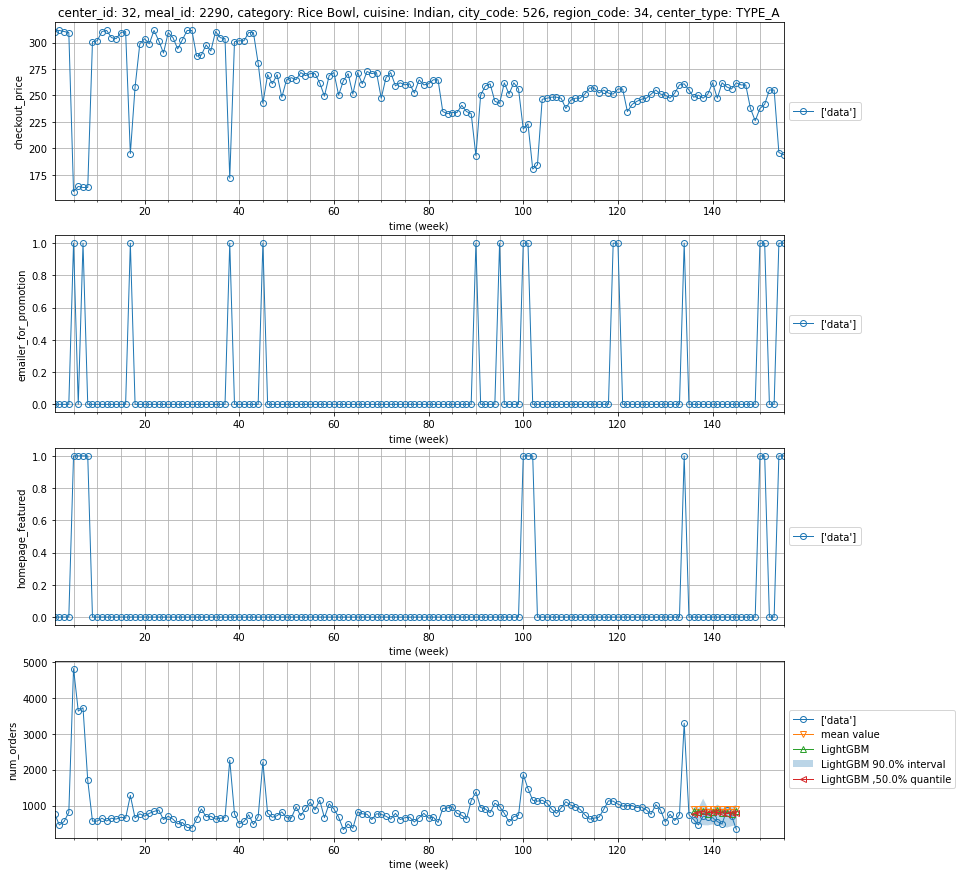

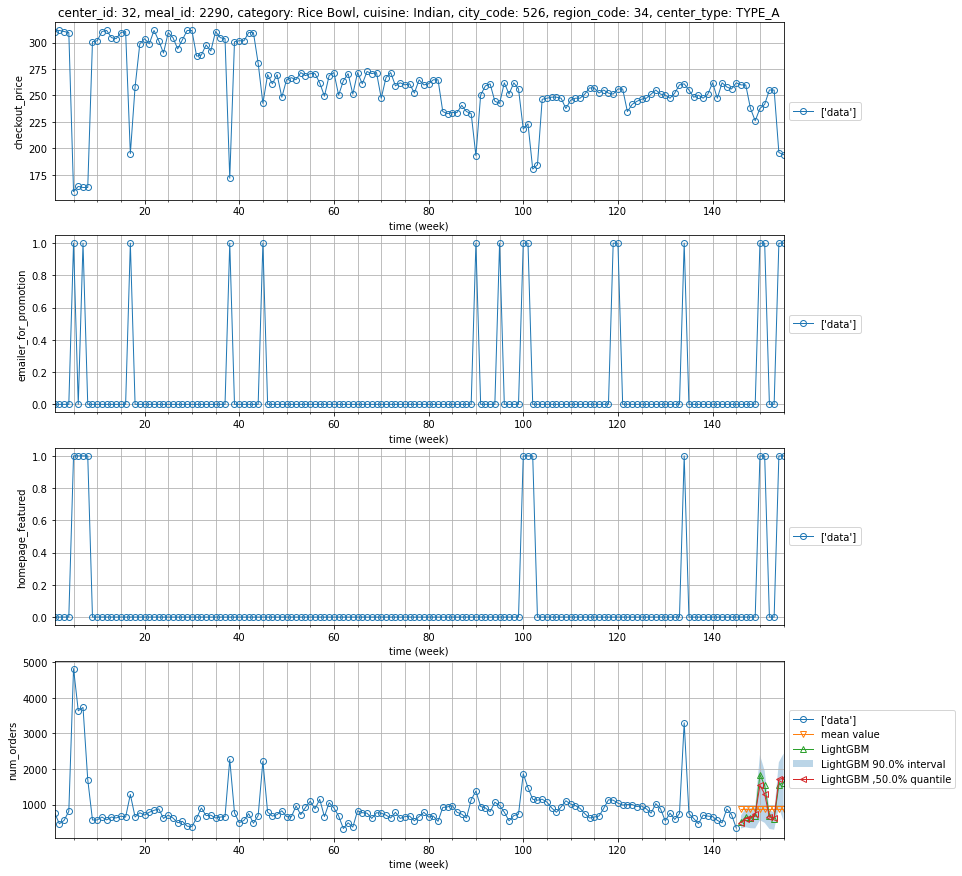

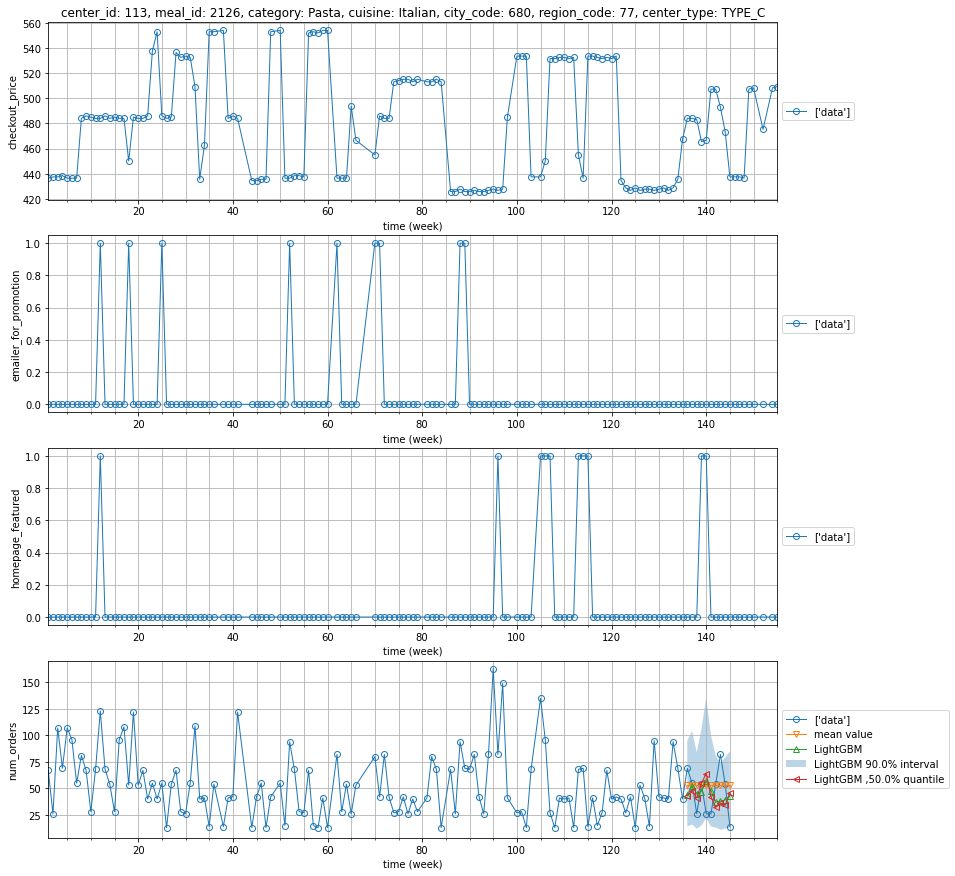

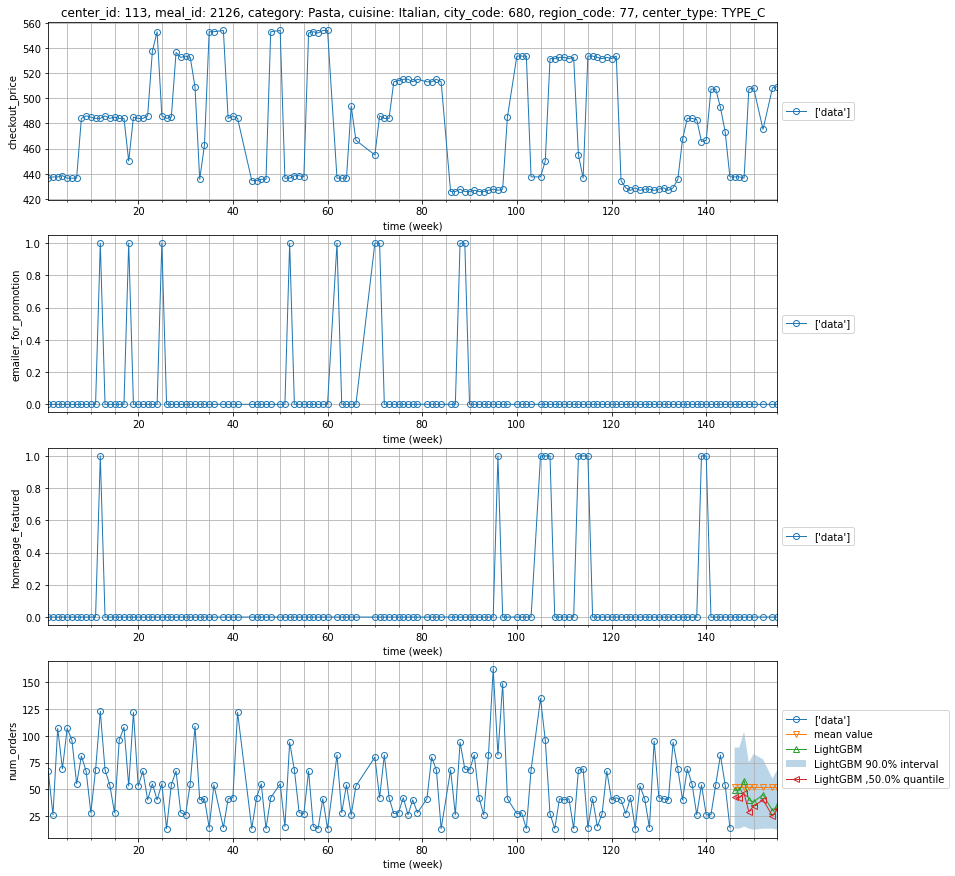

In [31]:
np.random.seed(1)  # for reproducible plots
if plot_ts > 0:
    for ind_ts in np.random.choice(num_ts, plot_ts, replace=False):
        for do_test in [True, False]:
            if do_test:
                preds_gbm = test_preds_gbm
                ts_inds_pred = [1, 2]
            else:
                preds_gbm = final_preds_gbm
                ts_inds_pred = [2, 3]

            # row indices of dataframe for the time series
            df_row_inds_train = np.arange(ts_inds[ind_ts, 0], ts_inds[ind_ts, ts_inds_pred[0]]) 
            df_row_inds_pred = np.arange(ts_inds[ind_ts, ts_inds_pred[0]], ts_inds[ind_ts, ts_inds_pred[1]])
            time_values_pred = list(df.iloc[df_row_inds_pred][t_var])  # time values for the predictions

            # mean value of the target for comparison
            target_values_train = df.iloc[df_row_inds_train][target_feature]
            test_pred1 = np.full([len(df_row_inds_pred)], target_values_train.mean())
        
            # predictions and corresponding confidence (quantile) estimates
            test_pred2 = []
            for ind, alpha in enumerate(alphas):
                target_values_pred_ids = df.iloc[df_row_inds_pred][id_var]
                mask_gbm = preds_gbm[ind][id_var].isin(target_values_pred_ids)
                test_pred2.append(preds_gbm[ind].loc[mask_gbm, target_feature].values)
                if alpha is None:
                    ind_use = ind
        
            # plot the data using the plotter object
            category_title_vals = list(df.iloc[df_row_inds_pred[0]][categorical_features].values)
            col_keyvals = {k:v for k,v in zip(categorical_features, category_title_vals)}
            plotter = ml_vis_eda.TimeSeriesPlotter(df)
            plotter.filter_data(col_keyvals)
            test_preds = np.array([test_pred1, test_pred2[ind_use]])
            plotter.plot_single_time_series(t_var, plot_cols, plot_cols, f'time ({t_var})', target_feature, 
            test_preds, algorithms, \
            [time_values_pred]*len(algorithms), test_pred2[1:], alphas[1:], default_algorithm)
plt.show()


<H3> Conclusions </H3>
A time series forecasting model was developed using gradient boosting algorithm (LightGBM) with lags of up to 20 weeks to forecast order demand and achieved a reasonable accuracy (R^2 = 85.7%) on the test data (weeks 136 to 145 for 3600 time series). The model can forecast RMSE predictions and confidence (quantile) estimates, and was optimized using feature engineering, feature selection and hyperparameter tuning in a semi-automated fashion. Slow (subtle) time-dependence of the features over the course of the data (155 weeks) was observed and its modeling can be investigated further. (e.g. capturing effects of inflation with slow price increases)